# Predicting Bike Rental Demand

**Important Note**: This notebook primarily aims to show how to manage missing data and generate predictions using a model. It does not serve as a comprehensive guide to building the most advanced model for this dataset or showcase the best practices in feature engineering. To keep explanations clear, we will use simplified assumptions and straightforward models. For applications in the real world, you should employ more sophisticated approaches and feature engineering methods. However, we will present a more complex model towards the end of this notebook for you to explore, albeit with less detailed guidance.

In [1]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate(".."); Pkg.instantiate(); 

  Activating project at `~/.julia/dev/RxInfer/examples`


In [2]:
using RxInfer

## Preamble: Enabling Predictions
`RxInfer.jl` facilitates predictions in two primary ways. 

1. **Implicit Prediction**: By adding `missing` instances directly into the data, which are then treated as regular observations during inference.
   
2. **Explicit Prediction**: By defining a separate data variable in the model. This approach doesn't necessitate passing `missing` instances as the data variable but does require specifying the `predictvar` argument in the inference function.

### Example
Consider the following model:

In [3]:
@model function example_model(y)

    h ~ NormalMeanPrecision(0, 1.0)
    x ~ NormalMeanPrecision(h, 1.0)
    y ~ NormalMeanPrecision(x, 10.0)
end

In [4]:
# Implicit Prediction
result = infer(model = example_model(), data = (y = missing,))

Inference results:
  Posteriors       | available for (h, x)
  Predictions      | available for (y)


In [5]:
# Explicit Prediction
result = infer(model = example_model(), predictvars = (y = KeepLast(),))

Inference results:
  Posteriors       | available for (h, x)
  Predictions      | available for (y)


Both approaches yield the same results, but the choice depends on personal preferences and the model's structure. In scenarios with a clear distinction between observed and predicted variables, the explicit method is preferable. However, our subsequent example will not differentiate between observations and predictions, as it utilizes a state space representation.

In [6]:
using CSV, DataFrames, Plots

## Objective
This example aims to simultaneously learn the dynamics of the feature space and predict hourly bike rental demand through reactive message passing, a signature approach of `RxInfer.jl`.

## Dataset Source
Data for this example study is sourced from the Kaggle [Bike Count Prediction Dataset](https://www.kaggle.com/datasets/brajeshmohapatra/bike-count-prediction-data-set). For the purpose of this example, the original dataset from Kaggle has been adapted by removing categorical variables such as season, holiday, and working day. Additionally we take only 500 entries. This modification allows us to focus on modeling the continuous variables without additional complexities of handling categorical data. Nevertheless, this extension is feasible within `RxInfer.jl`.

In [7]:
# Load the data
df = CSV.read("../data/bike_count/modified_bicycle.csv", DataFrame)
df[1:10, :]

Row,datetime,temp,atemp,humidity,windspeed,count
,String31,Float64,Float64,Float64,Float64,Int64
1,2011-01-01 0:00:00,9.84,14.395,81.0,0.0,16
2,2011-01-01 1:00:00,9.02,13.635,80.0,0.0,40
3,2011-01-01 2:00:00,9.02,13.635,80.0,0.0,32
4,2011-01-01 3:00:00,9.84,14.395,75.0,0.0,13
5,2011-01-01 4:00:00,9.84,14.395,75.0,0.0,1
6,2011-01-01 5:00:00,9.84,12.88,75.0,6.0032,1
7,2011-01-01 6:00:00,9.02,13.635,80.0,0.0,2
8,2011-01-01 7:00:00,8.2,12.88,86.0,0.0,3
9,2011-01-01 8:00:00,9.84,14.395,75.0,0.0,8


In [8]:
# we reserve few samples for prediction
n_future = 24

# `x` is a sequence of observed features
X = Union{Vector{Float64}, Missing}[[row[i] for i in 2:(ncol(df))-1] for row in eachrow(df)][1:end-n_future]

# `y` is a sequence of "count" bicycles
y = Union{Float64, Missing}[df[:, "count"]...][1:end-n_future]

state_dim = length(X[1]); # dimensionality of feature space

## Generative Model with Priors
We present a generative model that delineates the latent dynamics of feature evolution, represented by $\mathbf{h}_t$, and their link to the bike rental counts, $\mathbf{y}_t$.

### Equations and Priors
1. **Feature Dynamics with Prior**:
   - Prior: $\mathbf{a} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
   - Dynamics: $\mathbf{h}_t \sim \mathcal{N}(\mathbf{A h}_{t-1}, \mathbf{Q})$
   - $\mathbf{A}$ is the transition matrix, reshaped from the prior vector $\mathbf{a}$, and $\mathbf{Q}$ represents process noise.

2. **Noisy Observations**:
   - $\mathbf{x}_t \sim \mathcal{N}(\mathbf{h}_t, \mathbf{P})$
   - Represents the observed noisy state of the features.

3. **Count Prediction with Prior**:
   - Prior: $\boldsymbol{\theta} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
   - Prediction: $y_t \sim \mathcal{N}(\text{softplus}(\boldsymbol{\theta}^\top\mathbf{h}_t), \sigma^2)$
   - Models the bike rental count as influenced by a non-linear transformation of the hidden state.

### Interpretation
- This framework aims to simultaneously infer the transition matrix $\mathbf{A}$ and the regression parameters $\boldsymbol{\theta}$, providing a comprehensive view of the feature space dynamics and the count prediction.
- By employing Gaussian priors on both $\mathbf{a}$ and $\boldsymbol{\theta}$, we incorporate beliefs about their distributions.
- The inference process aims to discover these underlying dynamics, enabling predictions of both features $\mathbf{x}_t$ and counts $y_t$.

In [9]:
# # We augument the dataset with missing entries for 24 hours ahead
append!(X, repeat([missing], n_future))
append!(y, repeat([missing], n_future));

In [10]:
# Function to perform the state transition in the model.
# It reshapes vector `a` into a matrix and multiplies it with vector `x` to simulate the transition.
function transition(a, x)
    nm, n = length(a), length(x)
    m = nm ÷ n  # Calculate the number of rows for reshaping 'a' into a matrix
    A = reshape(a, (m, n))  
    return A * x
end


transition (generic function with 1 method)

In [11]:
# The dotsoftplus function combines a dot product and softplus transformation.
# While useful for ensuring positivity, it may not be the optimal choice for all scenarios,
# especially if the data suggests other forms of relationships or distributions.
import StatsFuns: softplus
dotsoftplus(a, x) = softplus(dot(a, x))

dotsoftplus (generic function with 1 method)

In [12]:
# model definction
@model function bicycle_ssm(x, y, h0, θ0, a0, Q, s)

    a ~ a0
    θ ~ θ0
    h_prior ~ h0

    h_prev = h_prior
    for i in eachindex(y)
        
        h[i] ~ MvNormal(μ=transition(a, h_prev), Σ=Q)
        x[i] ~ MvNormal(μ=h[i], Σ=diageye(state_dim))
        y[i] ~ Normal(μ=dotsoftplus(θ, h[i]), σ²=s)
        h_prev = h[i]
    end

end

In [13]:
# In this example, we opt for a basic Linearization approach for the transition and dotsoftplus functions.
# However, alternative methods like Unscented or CVI approximations can also be considered.
bicycle_ssm_meta = @meta begin 
    transition() -> Linearization()
    dotsoftplus() -> Linearization()
end

GraphPPL.MetaSpecification(GraphPPL.MetaObject[transition() -> Linearization(), dotsoftplus() -> Linearization()], Union{GraphPPL.GeneralSubModelMeta, GraphPPL.SpecificSubModelMeta}[])

In [14]:
# prior_h: Based on first observation, assuming initial state is similar with equal variance.
prior_h = MvNormalMeanCovariance(X[1], diageye(state_dim))
# prior_θ, prior_a: No initial bias, parameters independent with equal uncertainty.
prior_θ = MvNormalMeanCovariance(zeros(state_dim), diageye(state_dim))
prior_a = MvNormalMeanCovariance(zeros(state_dim^2), diageye(state_dim^2));

In [15]:
# the deterministic relationsships (transition) and (dotsoftplus) will induce loops in the graph representation of our model, this necessiates the initialization of the messages
imessages = @initialization begin
    μ(h) = prior_h
    μ(a) = prior_a
    μ(θ) = prior_θ
end
# Assumptions about the model parameters:
# Q: Process noise based on observed features' variance, assuming process variability reflects observed features variability.
# s: Observation noise based on observed data variance, directly estimating variance in the data, important for predictions
bicycle_model = bicycle_ssm(h0=prior_h, θ0=prior_θ, a0=prior_a, Q=var(filter(!ismissing, X)).*diageye(state_dim), s=var(filter(!ismissing, y)))

result = infer(
    model = bicycle_model,
    data  = (x=X, y=y), 
    options = (limit_stack_depth = 500, ), 
    returnvars = KeepLast(),
    predictvars = KeepLast(),
    initialization = imessages,
    meta = bicycle_ssm_meta,
    iterations = 20,
    showprogress=true,
)

Progress: 100%|█████████████████████████████████████████| Time: 0:02:36


Inference results:
  Posteriors       | available for (a, h, h_prior, θ)
  Predictions      | available for (y, x)


In [16]:
# For a sake of this example, we extract only predictions
mean_y, cov_y = mean.(result.predictions[:y]), cov.(result.predictions[:y])
mean_x, cov_x = mean.(result.predictions[:x]), var.(result.predictions[:x])

mean_x1, cov_x1 = getindex.(mean_x, 1), getindex.(cov_x, 1)
mean_x2, cov_x2 = getindex.(mean_x, 2), getindex.(cov_x, 2)
mean_x3, cov_x3 = getindex.(mean_x, 3), getindex.(cov_x, 3)
mean_x4, cov_x4 = getindex.(mean_x, 4), getindex.(cov_x, 4);


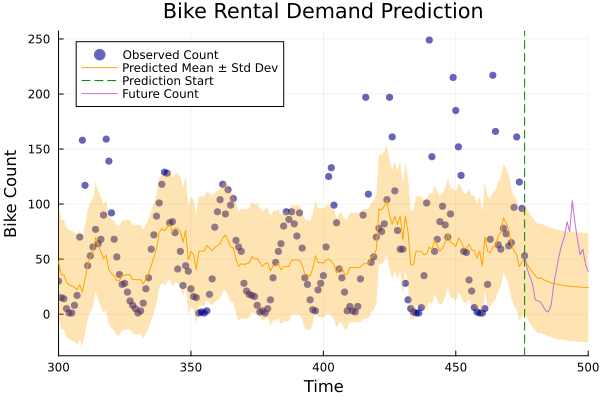

In [17]:
slice = (300, length(y))
data = df[:, "count"][length(y)-n_future:length(y)]

p = scatter(y, 
            color=:darkblue, 
            markerstrokewidth=0,
            label="Observed Count", 
            alpha=0.6)

# Plotting the mean prediction with variance ribbon
plot!(mean_y, ribbon=sqrt.(cov_y), 
      color=:orange, 
      fillalpha=0.3,
      label="Predicted Mean ± Std Dev")

# Adding a vertical line to indicate the start of the future prediction
vline!([length(y)-n_future], 
       label="Prediction Start", 
       linestyle=:dash, 
       linecolor=:green)

# Future (unobserved) data
plot!(length(y)-n_future:length(y), data, label="Future Count")

# Adjusting the limits
xlims!(slice)

# Enhancing the plot with titles and labels
title!("Bike Rental Demand Prediction")
xlabel!("Time")
ylabel!("Bike Count")

# Adjust the legend
legend=:topright

# Show the final plot
display(p)

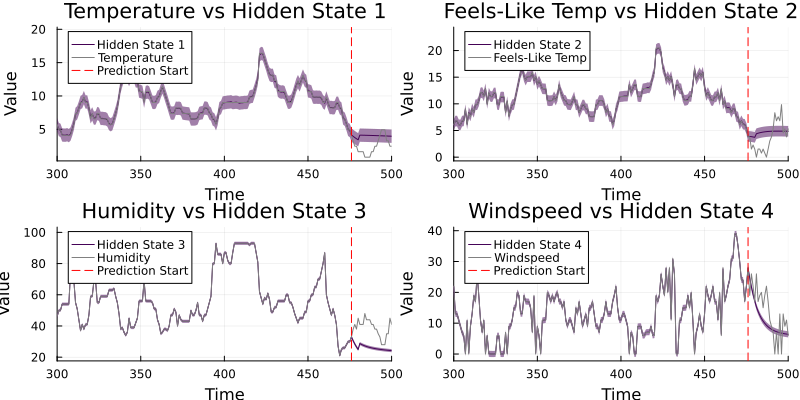

In [18]:
using Plots

# Define a color palette
palette = cgrad(:viridis)

# Plot the hidden states with observations
p1 = plot(mean_x1, ribbon=sqrt.(cov_x1), color=palette[1], label="Hidden State 1", legend=:topleft)
plot!(df[!, :temp], color=:grey, label="Temperature")
vline!([length(y)-n_future], linestyle=:dash, color=:red, label="Prediction Start")
xlabel!("Time")
ylabel!("Value")
title!("Temperature vs Hidden State 1")

p2 = plot(mean_x2, ribbon=sqrt.(cov_x2), color=palette[2], label="Hidden State 2", legend=:topleft)
plot!(df[!, :atemp], color=:grey, label="Feels-Like Temp")
vline!([length(y)-n_future], linestyle=:dash, color=:red, label="")
xlabel!("Time")
ylabel!("Value")
title!("Feels-Like Temp vs Hidden State 2")

p3 = plot(mean_x3, ribbon=sqrt.(cov_x3), color=palette[3], label="Hidden State 3", legend=:topleft)
plot!(df[!, :humidity], color=:grey, label="Humidity")
vline!([length(y)-n_future], linestyle=:dash, color=:red, label="Prediction Start")
xlabel!("Time")
ylabel!("Value")
title!("Humidity vs Hidden State 3")

p4 = plot(mean_x4, ribbon=sqrt.(cov_x4), color=palette[4], label="Hidden State 4", legend=:topleft)
plot!(df[!, :windspeed], color=:grey, label="Windspeed")
vline!([length(y)-n_future], linestyle=:dash, color=:red, label="Prediction Start")
xlabel!("Time")
ylabel!("Value")
title!("Windspeed vs Hidden State 4")

for p in [p1, p2, p3, p4]
    xlims!(p, first(slice), last(slice))
end

plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 400))

## Improving the model

While our current model's predictions may not closely match real-world data, it's important to recognize that certain assumptions and simplifications were made that might have affected the results. The model is essentially a theoretical framework, highlighting the ability to simultaneously deduce states, parameters, and predictions, with an emphasis on the analysis's predictive aspect.

To enhance the model and refine its predictions, we can employ variational message passing. This method enables us to eliminate loops within the model by substituting initial messages with initial marginal distributions. This is achieved by utilizing `ContinuousTransition` (also referred to as `CTransition`) and `SoftDot` (aka `softdot`) nodes. These nodes facilitate the variational approximation of the transition matrix and the dot product, respectively.

In [19]:
transformation = a -> reshape(a, state_dim, state_dim)

#39 (generic function with 1 method)

In [20]:
# model definction
@model function bicycle_ssm_advanced(x, y, h0, θ0, a0, P0, γ0)

    a ~ a0
    θ ~ θ0
    h_prior ~ h0
    P ~ P0
    γ ~ γ0

    h_prev = h_prior
    for i in eachindex(y)
        
        h[i] ~ CTransition(h_prev, a, P)
        x[i]  ~ MvNormal(μ=h[i], Λ=diageye(state_dim))
        _y[i] ~ softdot(θ, h[i], γ)
        y[i] ~ Normal(μ=softplus(_y[i]), γ=1e4)
        h_prev = h[i]
    end

end

In [21]:
bicycle_ssm_advanced_meta = @meta begin 
    softplus() -> Linearization()
    CTransition() -> CTMeta(transformation)
end

GraphPPL.MetaSpecification(GraphPPL.MetaObject[log1pexp() -> Linearization(), ContinuousTransition() -> ContinuousTransitionMeta{var"#39#40"}(var"#39#40"())], Union{GraphPPL.GeneralSubModelMeta, GraphPPL.SpecificSubModelMeta}[])

In [22]:
bicycle_ssm_advanced_constraints = @constraints begin
    q(h_prior, h, a, P, γ, _y, y, θ) = q(h_prior, h)q(a)q(P)q(γ)q(_y, y)q(θ)
end

Constraints: 
    q(h_prior, h, a, P, γ, _y, y, θ) = q(h_prior, h)q(a)q(P)q(γ)q(_y, y)q(θ)


In [23]:
prior_P = ExponentialFamily.WishartFast(state_dim+2, inv.(var(filter(!ismissing, X))) .* diageye(state_dim))
prior_a = MvNormalMeanPrecision(ones(state_dim^2), diageye(state_dim^2));

prior_γ = GammaShapeRate(1.0, var(filter(!ismissing, y)))
prior_h = MvNormalMeanPrecision(X[1], diageye(state_dim))
prior_θ = MvNormalMeanPrecision(ones(state_dim), diageye(state_dim))

imarginals = @initialization begin 
    q(h) = prior_h
    q(a) = prior_a
    q(P) = prior_P
    q(γ) = prior_γ
    q(θ) = prior_θ
end

bicycle_model_advanced = bicycle_ssm_advanced(h0=prior_h, θ0=prior_θ, a0=prior_a, P0=prior_P, γ0=prior_γ)

result_advanced = infer(
    model = bicycle_model_advanced,
    data  = (x=X, y=y), 
    options = (limit_stack_depth = 500, ), 
    returnvars = KeepLast(),
    predictvars = KeepLast(),
    initialization = imarginals,
    constraints = bicycle_ssm_advanced_constraints,
    meta = bicycle_ssm_advanced_meta,
    iterations = 10,
    showprogress=true,
)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:45


Inference results:
  Posteriors       | available for (a, P, _y, γ, h, h_prior, θ)
  Predictions      | available for (y, x)


In [24]:
# For a sake of this example, we extract only predictions
mean_y, cov_y = mean.(result_advanced.predictions[:y]), cov.(result_advanced.predictions[:y])

([16.000001019202035, 39.999999977143176, 32.000000296906734, 13.000001230567127, 1.0000017352030168, 1.0000019345942128, 2.0000015515351452, 3.00000141495801, 8.000001680638599, 14.00000184505535  …  30.833408925477357, 30.498191664085716, 30.189153581494228, 29.90073939322114, 29.628352363188082, 29.368224564650916, 29.117313865318383, 28.873223915430927, 28.634139368847748, 28.40003613909282], [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001  …  0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001])

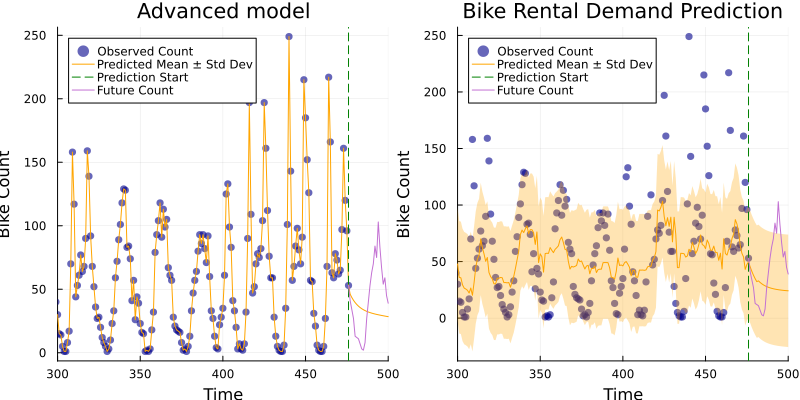

In [25]:
slice = (300, length(y))
data = df[:, "count"][length(y)-n_future:length(y)]

pa = scatter(y, 
            color=:darkblue, 
            markerstrokewidth=0,
            label="Observed Count", 
            alpha=0.6)

# Plotting the mean prediction with variance ribbon
plot!(mean_y, ribbon=sqrt.(cov_y), 
      color=:orange, 
      fillalpha=0.3,
      label="Predicted Mean ± Std Dev")

# Adding a vertical line to indicate the start of the future prediction
vline!([length(y)-n_future], 
       label="Prediction Start", 
       linestyle=:dash, 
       linecolor=:green)

# Future (unobserved) data
plot!(length(y)-n_future:length(y), data, label="Future Count")

# Adjusting the limits
xlims!(slice)

# Enhancing the plot with titles and labels
title!("Advanced model")
xlabel!("Time")
ylabel!("Bike Count")

# Adjust the legend
legend=:topright

# Show the final plot
plot(pa, p, size=(800, 400))